### **Install necessary Libraries**

In [1]:
##Import necessary libraries
import re
import nltk
import pandas as pd
import numpy as np
import textstat
import string
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score,ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from kerastuner.tuners import RandomSearch

C:\Users\chris\AppData\Local\Temp\ipykernel_17740\797017720.py:27: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# Download the necessary NLTK resources
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Preparation

The following steps were taken in order to create the dataset needed:
* Read the file 
* use NLTK to split the text into sentences.
* Get the reading age (Fog index) for these sentences.
* Create a dataframe from the result. 

In [1]:
##function to split a text into sentences
def split_sentences1(text):
    # Use NLTK's sentence tokenizer
    sentences = nltk.sent_tokenize(text)
    return sentences

In [4]:
##function to read the and return the content
def read_file(filename, encoding='utf-8'):
    with open(filename, 'r', encoding=encoding) as file:
        content = file.read()
    return content

In [5]:
##function to calculate the fog index of text
def calculate_fog_index(sentence):
    return textstat.textstat.gunning_fog(sentence)

In [6]:
#filename of the text file
filename = 'speech.txt'

# Read the file content
file_content = read_file(filename)

# Split the content into sentences
sentences = split_sentences1(file_content)

sentences

['Thank you very much for that warm welcome.',
 'You’ll have to excuse me if I cough during this speech; I’ve been up all night supergluing the backdrop.',
 'There are some things about last year’s conference I have tried to forget.',
 'But I will always remember the warmth I felt from everyone in the hall.',
 'You supported me all the way – thank you.',
 'This year marks a century since the end of the First World War.',
 'Just a few hundred yards from this conference centre stands a Hall of Memory, built to honour the sacrifice of men and women from this city in that terrible conflict.',
 'Inscribed within it are some familiar words: ‘AT THE GOING DOWN OF THE SUN, AND IN THE MORNING, WE WILL REMEMBER THEM.’\n\n \n\nWe do remember them.',
 'We remember the young men who left their homes to fight and die in the mud and horror of the trenches.',
 'We remember the sailors who shovelled coal into hellfire furnaces in the bowels of battleships.',
 'We remember the selflessness of a remarkab

In [7]:
# Calculate Fog Index for each sentence
results = []
for sentence in sentences:
    fog_index = calculate_fog_index(sentence)
    results.append({'Sentence': sentence, 'Fog Index': fog_index})

In [8]:
# Create a DataFrame from the results
df = pd.DataFrame(results)

In [9]:
#view the dataframe
df

,Sentence,Fog Index
0,Thank you very much for that warm welcome.,3.20
1,You’ll have to excuse me if I cough during thi...,9.71
2,There are some things about last year’s confer...,8.28
3,But I will always remember the warmth I felt f...,5.60
4,You supported me all the way – thank you.,8.20
...,...,...
528,When we come together there is no limit to wha...,5.20
529,Ours is a great country.,2.00
530,Our future is in our hands.,2.40
531,"Together, let’s seize it.",1.60


# Data Preprocessing

The following steps were taken to clean the prepocess the data:
* Remove punctuations and foreign characters
* change to lower case

In [10]:
##function to preprocess the text
def preprocess_text(text):
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace('’','')
    text = text.replace('–','')
    text = text.replace('……','')

    # Remove newline characters
    text = text.replace('\n', ' ')

    # Convert text to lowercase
    text = text.lower()

    return text

In [11]:
# Preprocess the 'Sentence' column
df['Sentence'] = df['Sentence'].apply(preprocess_text)

In [12]:
df['Sentence'] 

0              thank you very much for that warm welcome
1      youll have to excuse me if i cough during this...
2      there are some things about last years confere...
3      but i will always remember the warmth i felt f...
4                you supported me all the way  thank you
                             ...                        
528    when we come together there is no limit to wha...
529                              ours is a great country
530                           our future is in our hands
531                               together lets seize it
532                 together lets build a better britain
Name: Sentence, Length: 533, dtype: object

In [13]:
##save to csv
df.to_csv('data.csv', index=False)

In [14]:
##check the max value for possible outlier
max(df['Fog Index'])

40.4

8.0     101
9.0      52
12.0     52
4.0      47
3.0      39
11.0     39
2.0      33
10.0     30
14.0     29
5.0      26
16.0     17
13.0     16
6.0      14
15.0     10
7.0      10
18.0      6
1.0       4
17.0      3
21.0      2
0.0       1
40.0      1
23.0      1
Name: Fog Index, dtype: int64


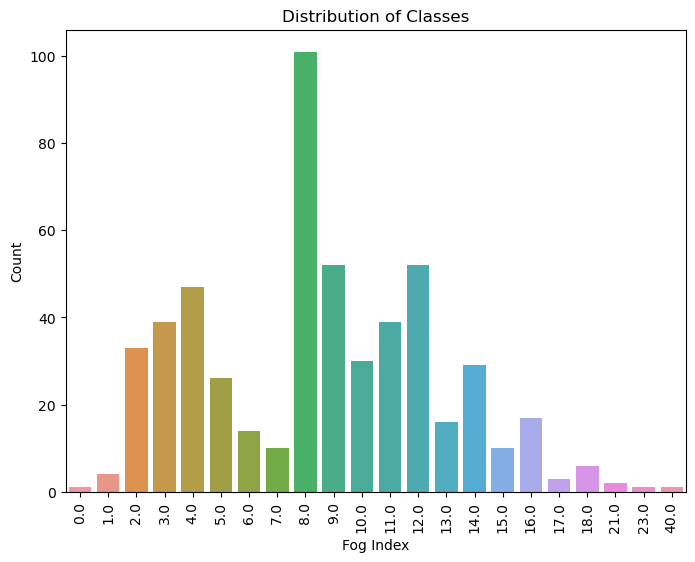

In [15]:

# check for the Target Variable Distribution
index=round(df['Fog Index'])
target_counts = index.value_counts()
print(target_counts)


plt.figure(figsize=(8, 6))
sns.countplot(data=df, x=index)
plt.title('Distribution of Classes')
plt.xlabel('Fog Index')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='Fog Index'>

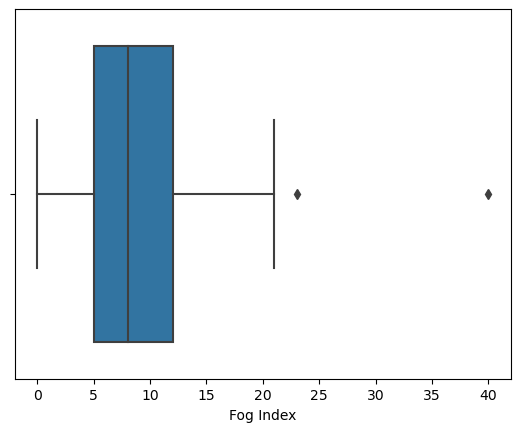

In [16]:
sns.boxplot(data=df,x=index)

In [17]:
##check value higher than 17 and update them to 18.0
df['Fog Index'] = index
df.loc[df['Fog Index'] > 17, 'Fog Index'] = 18.0
##check value below 6 and update them to 6.0
df.loc[df['Fog Index'] < 6, 'Fog Index'] = 6.0

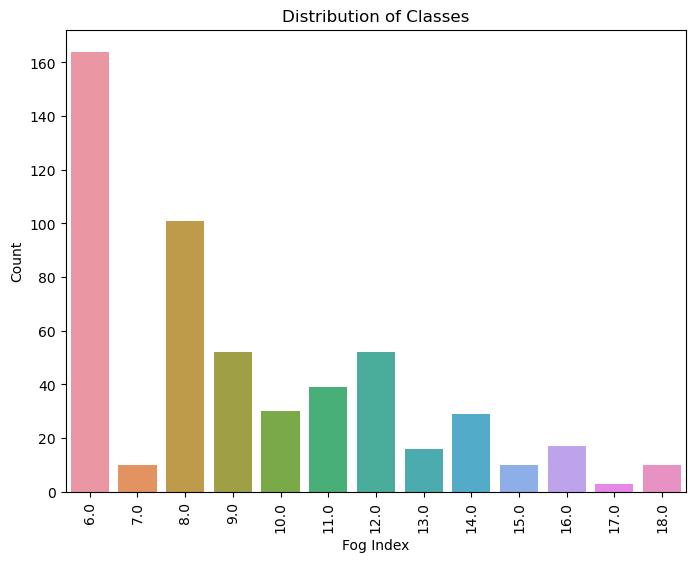

In [18]:
##plot to see new distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x=df['Fog Index'])
plt.title('Distribution of Classes')
plt.xlabel('Fog Index')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# LSTM

In [36]:
# Tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Sentence'])
sequences = tokenizer.texts_to_sequences(df['Sentence'])

In [37]:
# Pad sequences to a fixed length
# max_sequence_length = max(len(seq) for seq in sequences)
max_sequence_length = 100
x = pad_sequences(sequences, maxlen=max_sequence_length)

In [38]:
max_sequence_length

100

In [39]:
#get the shape of the x and y
print(x.shape,df['Fog Index'].shape)

(533, 100) (533,)


In [40]:
##apply randomoversampler to balance the data
rus = RandomOverSampler(random_state=42)

# Apply undersampling to the feature X and target variable y
X_res, y_res = rus.fit_resample(x, df['Fog Index'])

In [41]:
##check the new shape of x and y
print(X_res.shape,y_res.shape)

(2132, 100) (2132,)


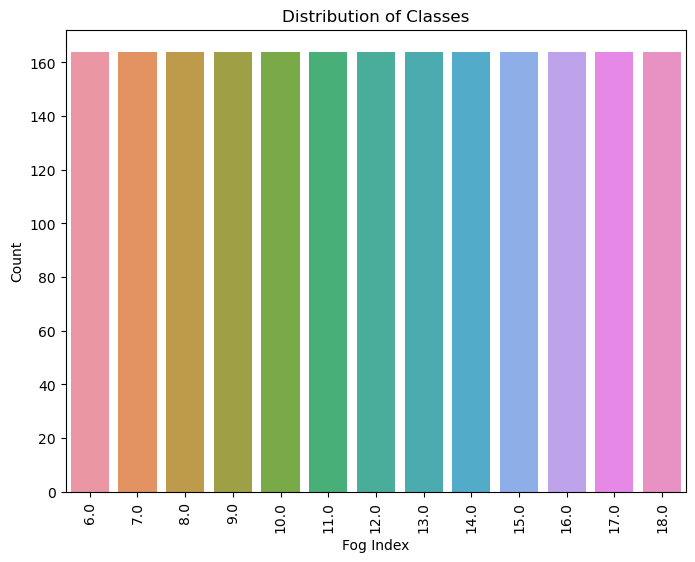

In [42]:

# check for the Target Variable Distribution
target_counts = y_res.value_counts()

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x=y_res)
plt.title('Distribution of Classes')
plt.xlabel('Fog Index')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



In [43]:
##split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
X,y=X_train,y_train
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Use LabelEncoder to transform the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.astype(int))
y_test = label_encoder.transform(y_test.astype(int))
y_val = label_encoder.transform(y_val.astype(int))

In [45]:
# Define the LSTM model
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          215424    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 13)                1677      
                                                                 
Total params: 348,685
Trainable params: 348,685
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Print the shapes of input data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", to_categorical(y_train).shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1364, 100)
Shape of y_train: (1364, 13)
Shape of X_test: (427, 100)
Shape of y_test: (427,)


In [47]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, to_categorical(y_train),
          validation_data=(X_val, to_categorical(y_val)),
          epochs=150, batch_size=32, callbacks=[early_stopping])

# Train the model without early stopping
# model.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=150, batch_size=128)

Epoch 1/150
43/43 [==============================] - 37s 596ms/step - loss: 2.4434 - accuracy: 0.1840 - val_loss: 2.1683 - val_accuracy: 0.2551
Epoch 2/150
43/43 [==============================] - 24s 551ms/step - loss: 1.7440 - accuracy: 0.4282 - val_loss: 1.4003 - val_accuracy: 0.5513
Epoch 3/150
43/43 [==============================] - 24s 547ms/step - loss: 0.9689 - accuracy: 0.7287 - val_loss: 0.8898 - val_accuracy: 0.7009
Epoch 4/150
43/43 [==============================] - 24s 557ms/step - loss: 0.5579 - accuracy: 0.8497 - val_loss: 0.5777 - val_accuracy: 0.8123
Epoch 5/150
43/43 [==============================] - 22s 523ms/step - loss: 0.3253 - accuracy: 0.9318 - val_loss: 0.5146 - val_accuracy: 0.8446
Epoch 6/150
43/43 [==============================] - 23s 529ms/step - loss: 0.2079 - accuracy: 0.9567 - val_loss: 0.4805 - val_accuracy: 0.8622
Epoch 7/150
43/43 [==============================] - 23s 527ms/step - loss: 0.1053 - accuracy: 0.9780 - val_loss: 0.3943 - val_accuracy:

In [48]:
# Evaluate the model
loss,accuracy = model.evaluate(X_test, to_categorical(y_test))
print(f"Test loss: {loss} and accuracy: {accuracy}")

14/14 [==============================] - 1s 70ms/step - loss: 0.3016 - accuracy: 0.9063
Test loss: 0.30156373977661133 and accuracy: 0.9063231945037842


In [49]:
# Get predictions on the test set
y_pred = model.predict(X_test)

##get predictions
pred = y_pred.argmax(axis=1)

# Compute classification metrics
report = classification_report(y_test, pred)

# Print the classification report
print(report)

14/14 [==============================] - 2s 53ms/step
              precision    recall  f1-score   support

           0       0.62      0.58      0.60        31
           1       1.00      1.00      1.00        38
           2       0.58      0.60      0.59        30
           3       0.69      0.80      0.74        25
           4       1.00      1.00      1.00        34
           5       0.92      1.00      0.96        35
           6       1.00      0.83      0.91        29
           7       0.97      1.00      0.99        33
           8       0.97      0.89      0.93        37
           9       1.00      1.00      1.00        39
          10       1.00      0.97      0.98        32
          11       1.00      1.00      1.00        34
          12       0.94      1.00      0.97        30

    accuracy                           0.91       427
   macro avg       0.90      0.90      0.90       427
weighted avg       0.91      0.91      0.91       427



# Glove and LSTM

In [50]:
##prepare glove for usage
embeddings_index = {}
word_index = tokenizer.word_index
embedding_dim_glove = 100
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [51]:
# Define the model
model_glove = Sequential()
model_glove.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim_glove, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model_glove.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_glove.add(Dense(13, activation='softmax'))

In [52]:
# Compile the model
model_glove.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
# Train the model
model_glove.fit(X_train, to_categorical(y_train), batch_size=64, epochs=150, validation_data=(X_val, to_categorical(y_val)), callbacks=[early_stopping])

Epoch 1/150
22/22 [==============================] - 37s 1s/step - loss: 2.4911 - accuracy: 0.1804 - val_loss: 2.3226 - val_accuracy: 0.3079
Epoch 2/150
22/22 [==============================] - 21s 941ms/step - loss: 2.1276 - accuracy: 0.3607 - val_loss: 1.8761 - val_accuracy: 0.4252
Epoch 3/150
22/22 [==============================] - 19s 873ms/step - loss: 1.6724 - accuracy: 0.4897 - val_loss: 1.4802 - val_accuracy: 0.5425
Epoch 4/150
22/22 [==============================] - 18s 837ms/step - loss: 1.3163 - accuracy: 0.6048 - val_loss: 1.2594 - val_accuracy: 0.5924
Epoch 5/150
22/22 [==============================] - 18s 826ms/step - loss: 1.1202 - accuracy: 0.6730 - val_loss: 1.0800 - val_accuracy: 0.6628
Epoch 6/150
22/22 [==============================] - 19s 861ms/step - loss: 0.9242 - accuracy: 0.7302 - val_loss: 0.9447 - val_accuracy: 0.7126
Epoch 7/150
22/22 [==============================] - 19s 865ms/step - loss: 0.8068 - accuracy: 0.7808 - val_loss: 0.7864 - val_accuracy: 0.

In [54]:
# Evaluate the model
loss_glove,accuracy_glove = model_glove.evaluate(X_test, to_categorical(y_test))
print(f"Test loss: {loss_glove} and accuracy: {accuracy_glove}")

14/14 [==============================] - 0s 25ms/step - loss: 0.2244 - accuracy: 0.9344
Test loss: 0.22438731789588928 and accuracy: 0.9344262480735779


In [55]:
# Get predictions on the test set
y_pred_glove = model_glove.predict(X_test)

##get predictions
pred_glove = y_pred_glove.argmax(axis=1)

# Compute classification metrics
report_glove = classification_report(y_test, pred_glove)

# Print the classification report
print(report_glove)

14/14 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.79      0.61      0.69        31
           1       1.00      1.00      1.00        38
           2       0.71      0.73      0.72        30
           3       0.85      0.88      0.86        25
           4       0.92      1.00      0.96        34
           5       0.95      1.00      0.97        35
           6       1.00      0.83      0.91        29
           7       0.97      1.00      0.99        33
           8       0.97      1.00      0.99        37
           9       1.00      1.00      1.00        39
          10       0.94      1.00      0.97        32
          11       1.00      1.00      1.00        34
          12       0.97      1.00      0.98        30

    accuracy                           0.93       427
   macro avg       0.93      0.93      0.93       427
weighted avg       0.93      0.93      0.93       427



# CNN

In [56]:
# Define the model
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim_glove, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_cnn.add(Dense(units=13, activation='softmax'))


# Compile the model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
# Train the model
model_cnn.fit(X_train, to_categorical(y_train), batch_size=64, epochs=150, validation_data=(X_val, to_categorical(y_val)), callbacks=[early_stopping])

Epoch 1/150
22/22 [==============================] - 18s 329ms/step - loss: 2.3647 - accuracy: 0.2383 - val_loss: 2.0588 - val_accuracy: 0.3079
Epoch 2/150
22/22 [==============================] - 8s 335ms/step - loss: 1.6691 - accuracy: 0.4941 - val_loss: 1.4501 - val_accuracy: 0.5484
Epoch 3/150
22/22 [==============================] - 9s 390ms/step - loss: 1.1525 - accuracy: 0.6584 - val_loss: 1.0108 - val_accuracy: 0.7097
Epoch 4/150
22/22 [==============================] - 6s 284ms/step - loss: 0.8016 - accuracy: 0.7654 - val_loss: 0.7672 - val_accuracy: 0.7918
Epoch 5/150
22/22 [==============================] - 6s 263ms/step - loss: 0.5593 - accuracy: 0.8548 - val_loss: 0.5881 - val_accuracy: 0.8768
Epoch 6/150
22/22 [==============================] - 6s 268ms/step - loss: 0.4149 - accuracy: 0.8966 - val_loss: 0.4996 - val_accuracy: 0.8856
Epoch 7/150
22/22 [==============================] - 6s 272ms/step - loss: 0.3057 - accuracy: 0.9362 - val_loss: 0.4840 - val_accuracy: 0.853

In [58]:
# Evaluate the model
loss_cnn,accuracy_cnn = model_cnn.evaluate(X_test, to_categorical(y_test))
print(f"Test loss: {loss_cnn} and accuracy: {accuracy_cnn}")

14/14 [==============================] - 0s 19ms/step - loss: 0.1843 - accuracy: 0.9461
Test loss: 0.1842813640832901 and accuracy: 0.9461358189582825


In [59]:
# Get predictions on the test set
y_pred_cnn = model_cnn.predict(X_test)

##get predictions
pred_cnn = y_pred_cnn.argmax(axis=1)

# Compute classification metrics
report_cnn = classification_report(y_test, pred_cnn)

# Print the classification report
print(report_cnn)

14/14 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.80      0.52      0.63        31
           1       1.00      1.00      1.00        38
           2       0.72      0.87      0.79        30
           3       0.92      0.88      0.90        25
           4       0.97      1.00      0.99        34
           5       1.00      1.00      1.00        35
           6       0.90      0.97      0.93        29
           7       0.97      1.00      0.99        33
           8       1.00      1.00      1.00        37
           9       1.00      1.00      1.00        39
          10       1.00      1.00      1.00        32
          11       1.00      1.00      1.00        34
          12       0.94      1.00      0.97        30

    accuracy                           0.95       427
   macro avg       0.94      0.94      0.94       427
weighted avg       0.95      0.95      0.94       427



# Traditional Algorithms

In [60]:
# Create the gradient boosting classifier

gbc = GradientBoostingClassifier()

# Train the classifier
gbc.fit(X_train, y_train)

# Predict on the training set
train_pred = gbc.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
print("Training Accuracy:", train_accuracy)

# Print the classification report for the training set
print("Classification Report for Training Set:")
print(classification_report(y_train, train_pred))

# Predict on the test set
test_pred = gbc.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print("Test Accuracy:", test_accuracy)

# Classification report for test set
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred))

Training Accuracy: 0.999266862170088
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       104
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00       101
           3       1.00      1.00      1.00       112
           4       1.00      1.00      1.00       102
           5       1.00      1.00      1.00       103
           6       1.00      0.99      1.00       109
           7       1.00      1.00      1.00       109
           8       1.00      1.00      1.00        97
           9       1.00      1.00      1.00       105
          10       1.00      1.00      1.00       112
          11       1.00      1.00      1.00       110
          12       1.00      1.00      1.00       101

    accuracy                           1.00      1364
   macro avg       1.00      1.00      1.00      1364
weighted avg       1.00      1.00      1.00      1364

Te

In [61]:
# Create the Random Forest classifier

clf = RandomForestClassifier(n_estimators=100)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the training set
train_pred_clf = clf.predict(X_train)
train_accuracy_clf = accuracy_score(y_train, train_pred_clf)
print("Training Accuracy:", train_accuracy_clf)

# Print the classification report for the training set
print("Classification Report for Training Set:")
print(classification_report(y_train, train_pred_clf))


# Predict on the test set
test_pred_clf = clf.predict(X_test)
test_accuracy_clf = accuracy_score(y_test, test_pred_clf)
print("Test Accuracy:", test_accuracy_clf)

# Classification report for test set
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred_clf))


Training Accuracy: 1.0
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00       101
           3       1.00      1.00      1.00       112
           4       1.00      1.00      1.00       102
           5       1.00      1.00      1.00       103
           6       1.00      1.00      1.00       109
           7       1.00      1.00      1.00       109
           8       1.00      1.00      1.00        97
           9       1.00      1.00      1.00       105
          10       1.00      1.00      1.00       112
          11       1.00      1.00      1.00       110
          12       1.00      1.00      1.00       101

    accuracy                           1.00      1364
   macro avg       1.00      1.00      1.00      1364
weighted avg       1.00      1.00      1.00      1364

Test Accuracy: 0

In [62]:
# Create a decision tree classifier

dtree = DecisionTreeClassifier()

# Train the classifier
dtree.fit(X_train, y_train)

# Predict on the training set
train_pred_tree = dtree.predict(X_train)
train_accuracy_tree = accuracy_score(y_train, train_pred_tree)
print("Training Accuracy:", train_accuracy_tree)

# Print the classification report for the training set
print("Classification Report for Training Set:")
print(classification_report(y_train, train_pred_tree))

# Predict on the test set
test_pred_tree = dtree.predict(X_test)
test_accuracy_tree = accuracy_score(y_test, test_pred_tree)
print("Test Accuracy:", test_accuracy_tree)

# Classification report for test set
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred_tree))

Training Accuracy: 1.0
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00       101
           3       1.00      1.00      1.00       112
           4       1.00      1.00      1.00       102
           5       1.00      1.00      1.00       103
           6       1.00      1.00      1.00       109
           7       1.00      1.00      1.00       109
           8       1.00      1.00      1.00        97
           9       1.00      1.00      1.00       105
          10       1.00      1.00      1.00       112
          11       1.00      1.00      1.00       110
          12       1.00      1.00      1.00       101

    accuracy                           1.00      1364
   macro avg       1.00      1.00      1.00      1364
weighted avg       1.00      1.00      1.00      1364

Test Accuracy: 0

In [63]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,  # Number of boosting rounds (trees)
    learning_rate=0.1,  # Learning rate
    random_state=42
)


# Train the classifier
xgb_model.fit(X_train, y_train)

# Predict on the training set
train_pred_xgb = xgb_model.predict(X_train)
train_accuracy_xgb = accuracy_score(y_train, train_pred_xgb)
print("Training Accuracy:", train_accuracy_xgb)

# Print the classification report for the training set
print("Classification Report for Training Set:")
print(classification_report(y_train, train_pred_xgb))


# Predict on the test set
test_pred_xgb = xgb_model.predict(X_test)
test_accuracy_xgb = accuracy_score(y_test, test_pred_xgb)
print("Test Accuracy:", test_accuracy_xgb)

# Classification report for test set
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred_xgb))

Training Accuracy: 1.0
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00       101
           3       1.00      1.00      1.00       112
           4       1.00      1.00      1.00       102
           5       1.00      1.00      1.00       103
           6       1.00      1.00      1.00       109
           7       1.00      1.00      1.00       109
           8       1.00      1.00      1.00        97
           9       1.00      1.00      1.00       105
          10       1.00      1.00      1.00       112
          11       1.00      1.00      1.00       110
          12       1.00      1.00      1.00       101

    accuracy                           1.00      1364
   macro avg       1.00      1.00      1.00      1364
weighted avg       1.00      1.00      1.00      1364

Test Accuracy: 0

In [64]:
# Create the ensemble model with voting as the ensemble method
ensemble_model = VotingClassifier(
    estimators=[
        ('gbc', gbc),
        ('clf', clf),
        ('dtree', dtree)
    ],
    voting='soft'  # 'soft' for probability-based voting, 'hard' for majority voting
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Predict on the training set
train_pred_en = ensemble_model.predict(X_train)
train_accuracy_en = accuracy_score(y_train, train_pred_en)
print("Training Accuracy:", train_accuracy_en)

# Print the classification report for the training set
print("Classification Report for Training Set:")
print(classification_report(y_train, train_pred_en))


# Predict on the test set
test_pred_en = ensemble_model.predict(X_test)
test_accuracy_en = accuracy_score(y_test, test_pred_en)
print("Test Accuracy:", test_accuracy_en)

# Classification report for test set
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred_en))

Training Accuracy: 1.0
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00       101
           3       1.00      1.00      1.00       112
           4       1.00      1.00      1.00       102
           5       1.00      1.00      1.00       103
           6       1.00      1.00      1.00       109
           7       1.00      1.00      1.00       109
           8       1.00      1.00      1.00        97
           9       1.00      1.00      1.00       105
          10       1.00      1.00      1.00       112
          11       1.00      1.00      1.00       110
          12       1.00      1.00      1.00       101

    accuracy                           1.00      1364
   macro avg       1.00      1.00      1.00      1364
weighted avg       1.00      1.00      1.00      1364

Test Accuracy: 0

# Hyper-parameter Tuning

In [65]:
##build model for tuning using CNN
def hp_model(hp):
    model_cnn = Sequential()
    model_cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim_glove, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))

    # Hyperparameter for number of filters in the Conv1D layer
    hp_filters = hp.Int('filters', min_value=64, max_value=256, step=32)
    # Hyperparameter for the size of the Conv1D kernel
    hp_kernel_size = hp.Int('kernel_size', min_value=3, max_value=7, step=2)

    model_cnn.add(Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation='relu'))
    model_cnn.add(MaxPooling1D(pool_size=2))

    # Hyperparameter for the number of units in the LSTM layer
    hp_lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    # Hyperparameter for LSTM dropout rate
    hp_lstm_dropout = hp.Float('lstm_dropout', min_value=0.1, max_value=0.5, step=0.1)

    model_cnn.add(LSTM(hp_lstm_units, dropout=hp_lstm_dropout, recurrent_dropout=0.2))
    model_cnn.add(Dense(units=13, activation='softmax'))

    model_cnn.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    return model_cnn


In [66]:
# Initialize the RandomSearch tuner
tuner = RandomSearch(
    hp_model,
    objective='val_accuracy',
    max_trials=5,  
    executions_per_trial=2
)

# Perform the hyperparameter search
tuner.search(X_train, to_categorical(y_train), epochs=50, validation_data=(X_val, to_categorical(y_val)), callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [67]:
# Get predictions on the test set
y_pred_cnn_hp = best_model.predict(X_test)

##get predictions
pred_cnn_hp = y_pred_cnn_hp.argmax(axis=1)

# Compute classification metrics
report_cnn_hp = classification_report(y_test, pred_cnn_hp)

# Print the classification report
print(report_cnn_hp)

14/14 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

           0       0.62      0.42      0.50        31
           1       1.00      1.00      1.00        38
           2       0.62      0.77      0.69        30
           3       0.84      0.84      0.84        25
           4       0.96      0.74      0.83        34
           5       0.97      0.94      0.96        35
           6       0.76      1.00      0.87        29
           7       0.97      1.00      0.99        33
           8       1.00      1.00      1.00        37
           9       1.00      1.00      1.00        39
          10       0.97      0.97      0.97        32
          11       1.00      1.00      1.00        34
          12       0.94      1.00      0.97        30

    accuracy                           0.90       427
   macro avg       0.90      0.90      0.89       427
weighted avg       0.91      0.90      0.90       427



In [68]:
# create a function to convert back the values
def convert_value(values):
    original_value = label_encoder.inverse_transform(values)
    return original_value

In [69]:
#create a dataframe of the predicted values
lstm_values = pd.DataFrame(pred,columns=['lstm_values']).apply(convert_value)
glove_values = pd.DataFrame(pred_glove,columns=['glove_values']).apply(convert_value)
cnn_values = pd.DataFrame(pred_cnn,columns=['cnn_values']).apply(convert_value)
hp_values = pd.DataFrame(pred_cnn_hp,columns=['hp_values']).apply(convert_value)
actual_values = pd.DataFrame(y_test,columns=['TextStat']).apply(convert_value)

gradient_boost = pd.DataFrame(test_pred,columns=['gradient_boost']).apply(convert_value)
random_forest = pd.DataFrame(test_pred_clf,columns=['random_forest']).apply(convert_value)
decision_trees = pd.DataFrame(test_pred_tree,columns=['decision_trees']).apply(convert_value)
xg_boost = pd.DataFrame(test_pred_xgb,columns=['xg_boost']).apply(convert_value)
ensemble = pd.DataFrame(test_pred_en,columns=['ensemble']).apply(convert_value)


In [70]:
ndf=pd.concat([actual_values,lstm_values, glove_values,cnn_values,hp_values,gradient_boost,random_forest,decision_trees,xg_boost,ensemble], axis=1)

In [71]:
ndf.head(30)

,TextStat,lstm_values,glove_values,cnn_values,hp_values,gradient_boost,random_forest,decision_trees,xg_boost,ensemble
0,10,10,10,10,10,10,10,10,10,10
1,18,18,18,18,18,18,18,18,18,18
2,16,16,16,16,16,16,16,16,16,16
3,15,15,15,15,15,15,15,15,15,15
4,18,18,18,18,18,18,18,18,18,18
5,12,13,14,13,12,14,10,10,16,11
6,16,16,16,16,16,16,16,16,16,16
7,11,11,11,11,11,11,11,11,11,11
8,6,6,6,8,6,6,6,8,8,8
9,8,6,9,8,9,8,11,8,8,8


In [72]:
#create a dataframe  to list the model performance
precision= [precision_score(y_test, pred, average='weighted'), precision_score(y_test, pred_glove, average='weighted'), precision_score(y_test, pred_cnn, average='weighted'),
            precision_score(y_test, test_pred, average='weighted'), precision_score(y_test, test_pred_clf, average='weighted'), precision_score(y_test, test_pred_tree, average='weighted'),
           precision_score(y_test, test_pred_xgb, average='weighted'),precision_score(y_test, test_pred_en, average='weighted'),precision_score(y_test, pred_cnn_hp, average='weighted')
           ]
recall= [
    recall_score(y_test, pred, average='weighted'),recall_score(y_test, pred_glove, average='weighted'),recall_score(y_test, pred_cnn, average='weighted'),
    recall_score(y_test, test_pred, average='weighted'),recall_score(y_test, test_pred_clf, average='weighted'),recall_score(y_test, test_pred_tree, average='weighted'),
    recall_score(y_test, test_pred_xgb, average='weighted'),recall_score(y_test, test_pred_en, average='weighted'),recall_score(y_test, pred_cnn_hp, average='weighted')
]

f1= [
    f1_score(y_test, pred, average='weighted'),f1_score(y_test, pred_glove, average='weighted'),f1_score(y_test, pred_cnn, average='weighted'),
    f1_score(y_test, test_pred, average='weighted'),f1_score(y_test, test_pred_clf, average='weighted'),f1_score(y_test, test_pred_tree, average='weighted'),
    f1_score(y_test, test_pred_xgb, average='weighted'),f1_score(y_test, test_pred_en, average='weighted'),f1_score(y_test, pred_cnn_hp, average='weighted')
]

models= ['LSTM','Glove-LSTM','Glove-CNN-LSTM','Gradient Boosting','Random Forest classifier','Decision Tree','XG Boosting','Ensemble model','CNN Hyperparameter Tuning']

precision = pd.Series(precision, name='Precision')
recall = pd.Series(recall, name='Recall')
f1= pd.Series(f1, name='F1')
models = pd.Series(models, name='Models')

report=pd.concat([models,round(precision,2), round(recall,2),round(f1,2)], axis=1)


# Sort the DataFrame by accuracy in descending order
report = report.sort_values(by='F1', ascending=False)

# Highlight the row with the best F1 score
report = report.style.highlight_max(subset='F1', color='lightgreen')

report

,Models,Precision,Recall,F1
2,Glove-CNN-LSTM,0.950000,0.950000,0.940000
1,Glove-LSTM,0.930000,0.930000,0.930000
3,Gradient Boosting,0.930000,0.930000,0.930000
6,XG Boosting,0.930000,0.940000,0.930000
4,Random Forest classifier,0.920000,0.930000,0.920000
7,Ensemble model,0.920000,0.930000,0.920000
0,LSTM,0.910000,0.910000,0.910000
5,Decision Tree,0.910000,0.920000,0.910000
8,CNN Hyperparameter Tuning,0.910000,0.900000,0.900000


In [73]:
##show the confusion matrix of the best model
cm = confusion_matrix(y_test, pred_cnn)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[16  0 10  2  1  0  0  0  0  0  0  0  2]
 [ 0 38  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0 26  0  0  0  2  0  0  0  0  0  0]
 [ 2  0  0 22  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 34  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 28  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 37  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 39  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 34  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 30]]


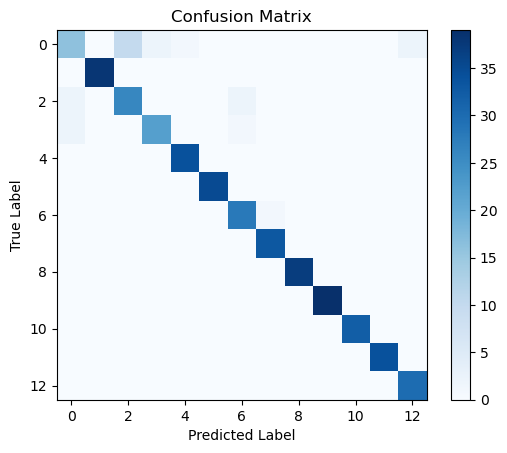

In [123]:
# Display the confusion matrix as a heatmap
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Prediction

In [75]:
##save the model
saved_model = {'model': model_cnn}
joblib.dump(saved_model, 'reading_age_model.pkl')

['reading_age_model.pkl']

In [76]:
##load the model
loadededmodel = joblib.load('reading_age_model.pkl')

In [77]:
#filename of the new text file
filename = 'new_speech.txt'

# Read the file content
new_file_content = read_file(filename)

# Split the content into sentences
new_sentences = split_sentences1(new_file_content)

new_sentences

['Conference, we meet at an absolutely crucial moment.',
 'In the next few months the future of our country will be decided for decades to come.',
 'And history will record that Liberal Democrats have been on the right side of the Brexit argument.',
 'Right to oppose Brexit in the first place.',
 'Right to predict a bad deal.',
 'And right to campaign for a ‘People’s Vote’.',
 'But this party knows better than any other that there are no prizes for being right.',
 'We have to win….',
 'And the good news is that we are winning the argument.',
 '=======\n\n \n\nBrexit has left millions of people feeling frustrated, powerless and unrepresented.',
 'So as we campaign for a different future, we are inviting those people into our movement.',
 'It is not only those who voted REMAIN that are with us.',
 'More and more people are thinking again.',
 'There is now a growing realisation that Brexit will be costly and painful: very costly and very painful if we crash out without a deal.',
 'The Bre

In [78]:
##preprocess the new data
processed_sentence = pd.Series(new_sentences).apply(preprocess_text)

In [81]:
##tokenize the words to sequences
sequences_new = tokenizer.texts_to_sequences(processed_sentence)
##pad the sequences to the max len used in the model i.e 100
x1 = pad_sequences(sequences_new, maxlen=100)

In [109]:
##predict using the loaded model
y1=loadededmodel['model'].predict(x1)

8/8 [==============================] - 0s 20ms/step


In [113]:
##get predictions
new_pred = y1.argmax(axis=1)

In [127]:
# create a dataframe of the reading age and the text
processed_data = pd.DataFrame(new_pred,columns=['predicted reading age']).apply(convert_value)
processed_data['text'] = processed_sentence

In [128]:
processed_data.head(10)

,predicted reading age,text
0,9,conference we meet at an absolutely crucial mo...
1,8,in the next few months the future of our count...
2,12,and history will record that liberal democrats...
3,8,right to oppose brexit in the first place
4,6,right to predict a bad deal
5,8,and right to campaign for a ‘peoples vote
6,8,but this party knows better than any other tha...
7,6,we have to win…
8,6,and the good news is that we are winning the a...
9,6,brexit has left millions of people feelin...
